In [1]:
from math import factorial
import os


import ele
import matplotlib.pyplot as plt
import numpy as np
import signac

from cmeutils.sampling import is_equilibrated, equil_sample
from cmeutils.structure import bond_distribution, angle_distribution, dihedral_distribution
from grits.coarsegrain import CG_System



def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    """Smoothing filter used on distributions and potentials

    Parameters
    ----------
    y: 1D array-like, required
        The data sequence to be smoothed
    window_size : int, required
        The size of the smoothing window to use; must be an odd number
    order: int, required
        The polynomial order used by the smoothing filter
    deriv:
    rate:

    Returns
    -------
    1D array-like
        Smoothed array of y after passing through the filter

    """
    if not (isinstance(window_size, int) and isinstance(order, int)):
        raise ValueError("window_size and order must be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")

    order_range = range(order + 1)
    half_window = (window_size - 1) // 2
    b = np.mat(
        [
            [k**i for i in order_range]
            for k in range(-half_window, half_window + 1)
        ]
    )
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    firstvals = y[0] - np.abs(y[1: half_window + 1][::-1] - y[0])
    lastvals = y[-1] + np.abs(y[-half_window - 1: -1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve(m[::-1], y, mode="valid")

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************

/home/chrisjones4/miniconda3/envs/pps-msibi/lib/python3.11/site-packages/mdtraj/formats/__init__.py:6: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from 

In [2]:
project = signac.get_project("../training-runs/single-chains/")

In [ ]:
job = project.open_job(id="29a7f0d216700e7c8534b8c11140ba06")

In [ ]:
job.sp

# Check if single-chain simulations are equilibrated:

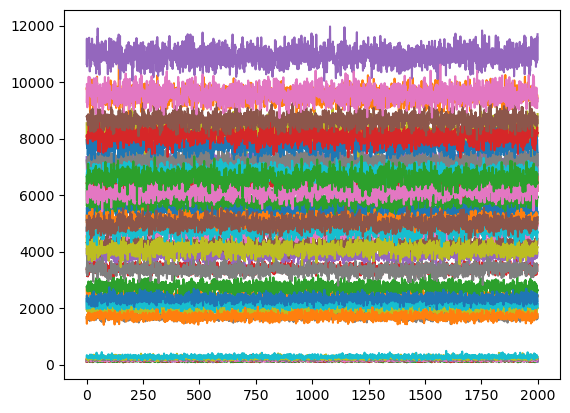

In [3]:
for job in project:
    data = np.genfromtxt(job.fn(f"log{job.doc.runs - 1}.txt"), names=True)
    pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    plt.plot(pe[-2000:])

In [4]:
target_gsd_file = "target_1monomer_per_bead.gsd"

# Sweep over chain lengths:

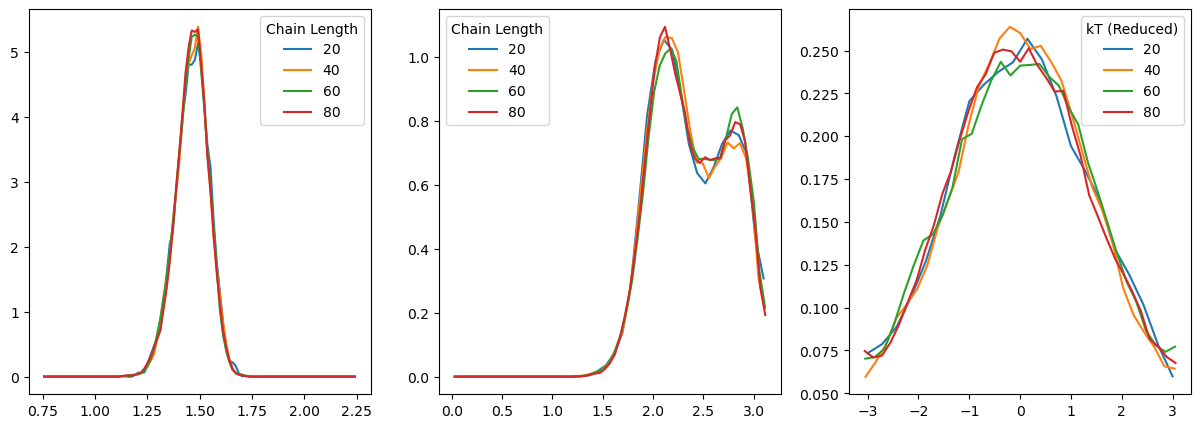

In [5]:
kT = 7.0
remove_charges = False
remove_hydrogens = False

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for chain_length, jobs in project.find_jobs(
    {"kT": kT, "remove_charges": remove_charges, "remove_hydrogens": remove_hydrogens}
).groupby("lengths"):
    for job in jobs:
        if job.sp.lengths == 2:
            continue
        gsd_file = job.fn(target_gsd_file)
        
        # BONDS:
        bond_dist = bond_distribution(
            gsd_file=gsd_file,
            A_name="A",
            B_name="A",
            start=-200,
            stop=-1,
            histogram=True,
            normalize=True,
            l_min=0.75,
            l_max=2.25
        )
        axs[0].plot(
            bond_dist[:,0],
            savitzky_golay(bond_dist[:,1], 5, 3),
            label=chain_length
        )
        
        # ANGLES:
        angle_dist = angle_distribution(
            gsd_file=gsd_file,
            A_name="A",
            B_name="A",
            C_name="A",
            start=-200,
            stop=-1,
            histogram=True,
            normalize=True
        )
        axs[1].plot(
            angle_dist[:,0],
            savitzky_golay(angle_dist[:,1], 5, 3),
            label=chain_length
        )

        # DIHEDRALS:
        dih_dist = dihedral_distribution(
            gsd_file=gsd_file,
            A_name="A",
            B_name="A",
            C_name="A",
            D_name="A",
            start=-200,
            stop=-1,
            histogram=True,
            normalize=True
            #l_min=0.5,
            #l_max=2.5
        )
        axs[2].plot(
            dih_dist[:,0],
            savitzky_golay(dih_dist[:,1], 5, 3),
            label=chain_length
        )

axs[0].legend(title="Chain Length")
axs[1].legend(title="Chain Length")
axs[2].legend(title="kT (Reduced)")

# Sweep Over Temps:

5.0 7ea9cc161a4adade13a5d185a7485271
6.0 20be19f2d2f22d60cec431585778953e
7.0 29a7f0d216700e7c8534b8c11140ba06
8.0 0cd49b57260f8fa6cceb2d9e8592c214


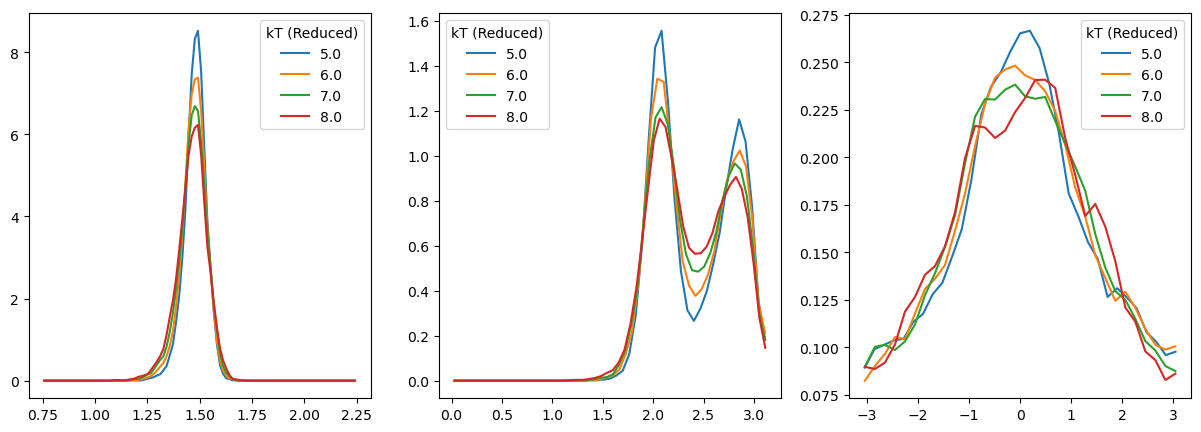

In [11]:
chain_length = 60
remove_charges = False
remove_hydrogens = True

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for kT, jobs in project.find_jobs(
    {"lengths": chain_length, "remove_charges": remove_charges, "remove_hydrogens": remove_hydrogens}
).groupby("kT"):
    for job in jobs:
        print(kT, job.id)
        gsd_file = job.fn(target_gsd_file)
        # BONDS:
        bond_dist = bond_distribution(
            gsd_file=gsd_file,
            A_name="A",
            B_name="A",
            start=-200,
            stop=-1,
            histogram=True,
            normalize=True,
            l_min=0.75,
            l_max=2.25
        )
        axs[0].plot(
            bond_dist[:,0],
            savitzky_golay(bond_dist[:,1], 5, 3),
            label=kT
        )
        # ANGLES:
        angle_dist = angle_distribution(
            gsd_file=gsd_file,
            A_name="A",
            B_name="A",
            C_name="A",
            start=-200,
            stop=-1,
            histogram=True,
            normalize=True
        )
        axs[1].plot(
            angle_dist[:,0],
            savitzky_golay(angle_dist[:,1], 5, 3),
            label=kT
        )
        # DIHEDRALS:
        dih_dist = dihedral_distribution(
            gsd_file=gsd_file,
            A_name="A",
            B_name="A",
            C_name="A",
            D_name="A",
            start=-200,
            stop=-1,
            histogram=True,
            normalize=True
        )
        axs[2].plot(
            dih_dist[:,0],
            savitzky_golay(dih_dist[:,1], 5, 3),
            label=kT
        )

axs[0].legend(title="kT (Reduced)")
axs[1].legend(title="kT (Reduced)")
axs[2].legend(title="kT (Reduced)")

# Compare Models: UA vs AA:

False 79ebd474affbd6dfbe5473f001ddd3d3
True 29a7f0d216700e7c8534b8c11140ba06


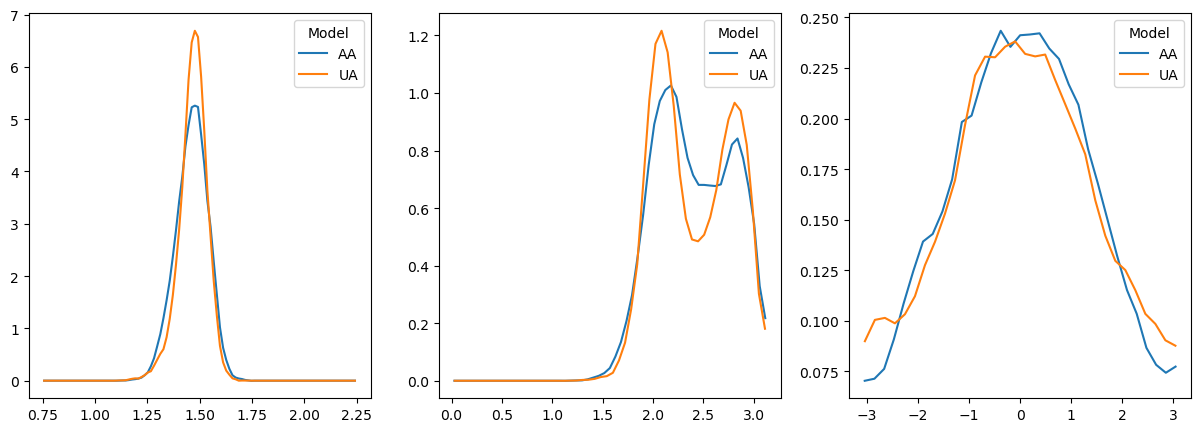

In [10]:
chain_length = 60
kT = 7.0
remove_charges = False

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for remove_H, jobs in project.find_jobs(
    {"lengths": chain_length, "remove_charges": remove_charges, "kT": kT}
).groupby("remove_hydrogens"):
    for job in jobs:
        print(remove_H, job.id)
        gsd_file = job.fn(target_gsd_file)
        # BONDS:
        if remove_H:
            label = "UA"
        else:
            label = "AA"
        bond_dist = bond_distribution(
            gsd_file=gsd_file,
            A_name="A",
            B_name="A",
            start=-200,
            stop=-1,
            histogram=True,
            normalize=True,
            l_min=0.75,
            l_max=2.25
        )
        axs[0].plot(
            bond_dist[:,0],
            savitzky_golay(bond_dist[:,1], 5, 3),
            label=label
        )
        # ANGLES:
        angle_dist = angle_distribution(
            gsd_file=gsd_file,
            A_name="A",
            B_name="A",
            C_name="A",
            start=-200,
            stop=-1,
            histogram=True,
            normalize=True
        )
        axs[1].plot(
            angle_dist[:,0],
            savitzky_golay(angle_dist[:,1], 5, 3),
            label=label
        )
        # DIHEDRALS:
        dih_dist = dihedral_distribution(
            gsd_file=gsd_file,
            A_name="A",
            B_name="A",
            C_name="A",
            D_name="A",
            start=-200,
            stop=-1,
            histogram=True,
            normalize=True
        )
        axs[2].plot(
            dih_dist[:,0],
            savitzky_golay(dih_dist[:,1], 5, 3),
            label=label
        )

axs[0].legend(title="Model")
axs[1].legend(title="Model")
axs[2].legend(title="Model")